# This is a script to read the sequencing results from the first construct (PGM_1.0 repeat) 
## Notebook started on the 10th April 2017


The construct has 32 repeats that are a series of Emx1.6 targets with 0-1-2 mismatches from the perfect target site (1-16). 
The same targets are repeated in 17-32 but in this case they have a TAG PAM instead of a TGG.

From the first experiment, it was decided that 2 different targets would be selected, a Fast target and a Slow target.
The Fast target correspond to the target #16 in the construct, which is the "perfect target" (EMx1.6 target).
The slow target is the target #1 in the construct.



#### The construct was tested in 4 different conditions:
-Embryos

-Larva (male and Female)

-Adult (male and Female)

-unmutated target

## Sequencing using amplicons

The “Amplicon” files contain the results of sequencing by PCR.

The repeats were sequenced in triplets, so the first 3 are sequenced in “amplicon 1” and so on..
So the Slow target is contained in “Amplicon 1” and the fast target is contained in “Amplicon 6”.

#### The sequencing primers for the Fast target are:

5' TTGAGAAGATAGACAGAATATGCGC 3'

5' TGAGACCGACCCTGACCTGATG 3'



## Check the mutation rate for the Untargeted-Fast

In here, I will only focus on the sequencing of the Fast target of the Untargeted conditions.

### I will manually correct for what we consider a sequencing error:

#### THE 3' "PRIMER" WILL BE JUST AFTER THE PAM, AND WILL INCLUDE THE POSSIBILITY OF HAVING THE SINGLE NUCLEOTIDE DELETIONS FOUND ON THE UNMUTATED TARGET. These are the 4 posibilities

TGGAGTACTGCTGAGACCGAC

T-GAGTACTGCTGAGACCGAC

TGGAG-ACTGCTGAGACCGAC

T-GAG-ACTGCTGAGACCGAC

### The read should be at least 100 pb to consider it

For the fast target, this is the whole sequenced repeat:

( | primer | target | spacer | primer)

ttgagaagatagacagaatatgcgc gcgccaccggttgatgtgattgg agtactgc tgagaccgaccctgacctgatg

### This is the construct

![PGM_1.0_repeats](PGM_1.0_repeats_small.jpg)



In [1]:
import sys
sys.path.insert(0, "/usr/lib/python3/dist-packages")
sys.path.insert(0, "/home/irsalvad/.local/lib/python3.5/site-packages")
#print('\n'.join(sys.path))

## First, load the packages to use


In [2]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
import random
from collections import Counter
random.seed(123)

import matplotlib.pyplot as plt
import numpy as np
import numpy


import math
from matplotlib import gridspec



## Open the amplicon file

As a first step I need to open the file with the results for the "Untargeted-Fast". 

This is in the file ('/Barcode-repeat-split/Untargeted/Untargeted_Amplicon6.txt') provided in the dryad repository (see manuscript for details).

Display the first 6 lines of the file


In [3]:
input_file ='../Barcode-repeat-split/Untargeted/Untargeted_Amplicon6.txt'
Amplicon6 = open(file= input_file)

for x in range(0,6):
    print("(line %d)" % (x), Amplicon6.readline())
Amplicon6.close()

(line 0) >QP75T:00025:00031

(line 1) TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGAGACTCGCGCGATCG

(line 2) >QP75T:00027:00042

(line 3) TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGAGACTGCTCGAGACGA

(line 4) >QP75T:00040:00025

(line 5) TTGAGAAGATAGACAGAATATGCGCGCGCCACCAATTGATGTGATTAGAGACCTTGCCCGATGCCTGACTAGAAGACCGAA



## Upload the primers and define the full construct sequence

In [4]:
primer5 = "TTGAGAAGATAGACAGAATATGCGC"

primer3_1 = "TGGAGTACTGCTGAGACCGA"
Full_1 = "TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGGAGTACTGCTGAGACCGA"

primer3_2 = "TGAGTACTGCTGAGACCGA"
Full_2 = "TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGAGTACTGCTGAGACCGA"

primer3_3 = "TGGAGACTGCTGAGACCGA"
Full_3 = "TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGGAGACTGCTGAGACCGA"

primer3_4 = "TGAGACTGCTGAGACCGA"
Full_4 = "TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGAGACTGCTGAGACCGA"

target = "TGATGTGAT"
print("my primer 5' is", primer5)

my primer 5' is TTGAGAAGATAGACAGAATATGCGC


## Define a function to find the primers in each amplified sequence

The function takes a line of the file as the input and fisrt check for each base if it matches with the first primer base. If it matches, then looks if the entire primer sequence matches.

Then open the file line by line to search for the primer sequence


In [5]:
## This is the function

def find_Primers(dna,my_p5,my_p3):
    p5=0; p3=0;
    substr = my_p5;
    for p in range(len(dna)):
        if dna[p] == substr[0]:
            if dna[p:p + len(substr)] == substr:
                p5=p
    substr = my_p3;
    for p in range(len(dna)):
        if dna[p] == substr[0]:
            if dna[p:p + len(substr)] == substr:
                p3=p + len(substr)
    return p5, p3


## Read the file and search line by line for the primers

As the file contains the amplified sequence name and then the sequence in the next line read each pair-numbered line (in python would be even-numbered as it starts from 0)

Using the function defined previously, search for both primers. The function returns the location of the most 5' and 3' locations of the primers, so the sequence can be spliced.

### All sequences found, are appended to the list "my_seqs", which will be used for further analysis.
### Find the proportion of Unmutated sequences in "my_seqs" and store it as a variable ("No_mut")



(as a test print the fist 5 sequences found)

In [6]:
Amplicon6 = open(file= input_file)

my_seqs = list()
primer_ends = 0
c=0 

for i, line in enumerate(Amplicon6):
    ## filter out all seqs with length less than 100
    if (i % 2 != 0) and (len(line)>=100):
        
        ## primer 3_1
        primer_ends = find_Primers(line,primer5,primer3_1)
        if primer_ends != (0,0) :
            s = line[primer_ends[0]:primer_ends[1]]
            my_seqs.append(s); x = s.find(Full_1)
            if x >= 0: c = c+1
        ## primer 3_2
        primer_ends = find_Primers(line,primer5,primer3_2)
        if primer_ends != (0,0) :
            s = line[primer_ends[0]:primer_ends[1]]
            my_seqs.append(s); x = s.find(Full_2)
            if x >= 0: c = c+1
        ## primer 3_3
        primer_ends = find_Primers(line,primer5,primer3_3)
        if primer_ends != (0,0) :
            s = line[primer_ends[0]:primer_ends[1]]
            my_seqs.append(s); x = s.find(Full_3)
            if x >= 0: c = c+1
        ## primer 3_4
        primer_ends = find_Primers(line,primer5,primer3_4)
        if primer_ends != (0,0) :
            s = line[primer_ends[0]:primer_ends[1]]
            my_seqs.append(s); x = s.find(Full_4)
            if x >= 0: c = c+1
            
                
No_mut = c/len(my_seqs)
            
Amplicon6.close()

for i in range(1): print("line",i+1, my_seqs[i])

print("\nNumber of unmutated targets =",c,"  proportion is %.4g" % (No_mut))
print("\nTotal number of targets is ", len(my_seqs))


line 1 TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGGAGTACTGCTGAGACCGA

Number of unmutated targets = 5417   proportion is 0.9701

Total number of targets is  5584


In [7]:
#out1 = open("my_seqs.txt","w") 
#for index, item in enumerate(my_seqs): 
#    out1.write(my_seqs[index])
#    out1.write("\n")
#out1.close()


## Define a function to search for the position of the primer

#### The output of the function is the first nucleotide of the seq primer. This will be used to read the Nmers


In [7]:
def find_target(dna,myprimer3):
    sub = None
    substr = myprimer3
    for p in range(len(dna)):
        if dna[p] == substr[0]:
            if dna[p:p + len(substr)] == substr:
                sub=p
    return sub

# Get all possible sequences from the sequencing primer if you read 9bp from the 3' primer

This is to know how many different deletions we have, and what is their distribution (e.g., is there one copy that is found in 25% of the sequences?


In [8]:
Nmer_pb = 9 ## Number of nucleotides in the target
N_unique = 0;
c= 0;
Nmer_LIST=list();
## Search in all amplified sequences:
for s in range(len(my_seqs)):
    seq = my_seqs[s]
    # primer 3_1
    x = find_target(seq,primer3_1)
    if x != None:             # if the primer can be found in the amplified sequence
        c = c + 1; Nmer_LIST.append(seq[x-Nmer_pb:x])
    # primer 3_2
    x = find_target(seq,primer3_2)
    if x != None:             # if the primer can be found in the amplified sequence
        c = c + 1; Nmer_LIST.append(seq[x-Nmer_pb:x])
    # primer 3_3
    x = find_target(seq,primer3_3)
    if x != None:             # if the primer can be found in the amplified sequence
        c = c + 1; Nmer_LIST.append(seq[x-Nmer_pb:x])
    # primer 3_4
    x = find_target(seq,primer3_4)
    if x != None:             # if the primer can be found in the amplified sequence
        c = c + 1; Nmer_LIST.append(seq[x-Nmer_pb:x])

UniqueNmers = set(Nmer_LIST)
N_unique = len(UniqueNmers)

Nmer_TOTALS = c;
print("number of Nmers:", len(UniqueNmers), "total:", Nmer_TOTALS,"\n") 
#print(c, N_unique, UniqueNmers)


number of Nmers: 18 total: 5584 



# Get the frequency of each of the Nmers for all the sites
### Use the unmutated proportion of targets as a reference. The ideal would be to have the lowest possible frequency of the "unmutated" Nmer, and that get many mutated Nmers at a frequency that is informative

In [9]:
Sorted_Lists_Vals = list()
Sorted_Lists_Labs = list()
Original_Nmers = list()

Unique_Nmer_freq= list()

### Get the real Nmer
Nmer_seq = target

UniqueList = list(UniqueNmers)
#print("for ", "distance:", len(UniqueList), "\n") 

## The Nmer_List contains all Nmers, search the frequency of each unique Nmer (uniques are in UniqueList)
Nmer_freq=list()
for i in range(len(UniqueList)):
    Unique_Nmer_freq.append([UniqueList[i],
                  #           '{:04d}'.format(Nmer_LIST.count(UniqueList[i]))]
                             Nmer_LIST.count(UniqueList[i])])
    #print(Unique_Nmer_freq)
Sorted_Unique = sorted(Unique_Nmer_freq, key=lambda Unique_Nmer_freq: Unique_Nmer_freq[1])
Sorted_Unique_labs = [item[0] for item in Sorted_Unique]
Sorted_Unique_vals = [item[1] for item in Sorted_Unique]

Sorted_Lists_Vals.append(Sorted_Unique_vals)
Sorted_Lists_Labs.append(Sorted_Unique_labs)
   
print(Sorted_Lists_Vals)
#print(Sorted_Lists_Labs)


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 6, 13, 22, 5522]]


## Plot all the Nmer freqs 

In the plot below, the frequency (Yaxis) of each Nmer (Xaxis) is shown. The Nmers are sorted from low to high frequency to see ir more clearly. In red we can see the proportion of Nmers with a sequence equal to the "unmutated" Nmer (Could be the unmutated or not).
As a dashed vertical line, we can see the real proportion of unmutated sequences.

Freq of the most common Nmer: 0.9889 	 the unmutated total: 5522 proportion : 0.9889


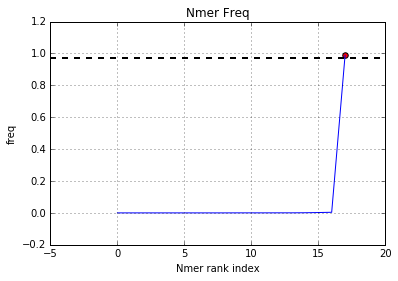

In [11]:
Vals = Sorted_Lists_Vals[0]
    
Labs = Sorted_Lists_Labs[0]
    
Rel_Vals = list()
for index, item in enumerate(Vals):
    Rel_Vals.append(Vals[index]/Nmer_TOTALS)
        
plt.plot(Rel_Vals)
plt.xlabel('Nmer rank index')
plt.ylabel('freq')
plt.title('Nmer Freq')
plt.grid(True)
#plt.axvline(x=Nmer90, ymin=0, ymax=1,linewidth=1, c='black', hold=None,linestyle="dashed")

plt.axhline(y=No_mut, xmin=0, xmax=1,linewidth=2, c='black', hold=None,linestyle="dashed")
## plot the sequence that is the same as the unmutated one
for index, item in enumerate(Labs):
    if item == target:
        #ax.annotate(Nmer,(index,Vals[index]), size = 14,color = "r")
        plt.scatter(index,Rel_Vals[index],s=30,c="r")
        if Rel_Vals[index] < 1 :
            print("Freq of the most common Nmer: %.5g" % (max(Vals)/Nmer_TOTALS),
                  "\t the unmutated total:", Vals[index],"proportion : %.5g" % (Vals[index]/Nmer_TOTALS) )

ax = plt.gca()

plt.show()

# Important for the simulations:

## Probability of a seq Error (After N cell cycles):

#### APROXIMATION USING NMERS    (1- unmutated Nmer )       = 1 - 0.9889 = 0.0111

